# MHW Spatial Detection & Tracking

Marine heatwave events are a specific type of extreme event that occurs when ocean temperatures exceed a threshold set based on long-term temperature patterns. Typically a marine heatwave event is determined when temperatures exceed the 90th percentile of temperatures for that day based on a 30-year climatology.

Existing python and R libraries do a great job of determining when these events occur and how long they persist for single timeseries, that could represent a point in space or an average over some area.

While this is helpful for communicating the severity of events through time, it obscures that heat stresses are distributed unequally through space and that there is an opportunity to track the event spatially as well.

To track events spatially there is a need to provide heatwave threshold detection functions that observe them in space using xarray. Once an xr.Dataset exists that can track them spatially, we can transition to using ocetrac to identify clusters of adjacent cells as a spatially distinct event, & follow them spatially.

This approach closely follows the example provided by the python library [ocetrac](https://github.com/ocetrac/ocetrac), and would not be possible without their pioneering work.

**Data**
This walkthrough uses satellite sea surface temperature from NOAA's OISSTv2 data product. The data has been subset to include only latitudes & longitudes for the Gulf of Maine and Scotian Shelf to use as a manageably sized pilot area. https://www.ncei.noaa.gov/products/optimum-interpolation-sst

**Steps:**
 - load sst and anomaly information
 - subset reference period for threshold creation
 - make quantile dataset that contains threshold for MHW
 - use quantile dataset to flag events
 - use some other function to do a rolling test to track event length and check for breaks

In [1]:
# Import libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os
import datetime
import dask

In [2]:
# Load OISST Data
sst = xr.open_mfdataset(
    "SST/*.nc", 
    chunks={  # this tells xarray to open the dataset as a dask array
        "lat": 4,
        "lon": 4,
        "time": -1})
sst

,Array,Chunk
Bytes,95.78 MiB,64 B
Shape,"(14945, 28, 60)","(1, 4, 4)"
Count,3153395 Tasks,1569225 Chunks
Type,float32,numpy.ndarray


In [5]:
# check chunks
# sst.chunks

In [6]:
# Add the ordinal day as a coordinate 
# to calculate avg and threshold percentiles based on
sst = sst.assign_coords(ordinal_day = sst.indexes["time"].dayofyear)
sst

,Array,Chunk
Bytes,95.78 MiB,64 B
Shape,"(14945, 28, 60)","(1, 4, 4)"
Count,3153395 Tasks,1569225 Chunks
Type,float32,numpy.ndarray


In [9]:
# Pull Data Range to use as a climate reference period (30-year norm)

# Print Climatology Years
ref_start = "1982-01-01"
ref_end   = "2011-12-31"
print(f"Using Climatology for the Following Date Range: {ref_start} to {ref_end}")

# Pull data for just that period
# Thresholds will come from here
ref_period = sst.sel(time = slice(ref_start, ref_end))
ref_period

Using Climatology for the Following Date Range: 1982-01-01 to 2011-12-31


<xarray.Dataset>
Dimensions:      (time: 10957, lat: 28, lon: 60)
Coordinates:
  * lat          (lat) float32 40.12 40.38 40.62 40.88 ... 46.38 46.62 46.88
  * lon          (lon) float32 288.1 288.4 288.6 288.9 ... 302.4 302.6 302.9
  * time         (time) datetime64[ns] 1982-01-01T12:00:00 ... 2011-12-31T12:...
    ordinal_day  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    sst          (time, lat, lon) float32 dask.array<chunksize=(1, 28, 60), meta=np.ndarray>

## Get MHW Thresholds from Reference Period

The climatological reference period is the period of data used to set expectations around what a normal temperature should be, and what an extreme event is. This period is typically 30-years for SST but can span a varying amount of time. The goal is for it to be sufficiently long to capture the inherent climatic variation.

In [13]:
# Thank you to Dr. Hillary Scannell for code help with chunks:
# https://github.com/ocetrac/ocetrac/blob/main/docs/examples/cmip6.ipynb

# Rechunk time dim
if ref_period.chunks:
    ref_period = ref_period.chunk({'time': -1})

# Set MHW threshold
mhw_pct = .9

# Get Quantile thresholds by modified ordinal day
threshold = ref_period.groupby(ref_period.ordinal_day).quantile(mhw_pct, dim='time', keep_attrs=True, skipna=True)

# # Cold Spells
# mcs_pct = .1
# cs_threshold = ref_period.groupby(ref_period.ordinal_day).quantile(mcs_pct, dim='time', keep_attrs=True, skipna=True)

# Checking Observations Against Thresholds

Mask out data that does not exceed thresholds so that its possible to track events through space using ocetrac.

In [14]:
# Check against the threshold

# 1. SST values
hot_water = sst.groupby(sst.ordinal_day).where(sst.groupby(sst.ordinal_day) > threshold)

# Cold Spells
# cold_water = sst.groupby(sst.ordinal_day).where(sst.groupby(sst.ordinal_day) < cs_threshold)

## Map Where Temperatures Exceed Threshold

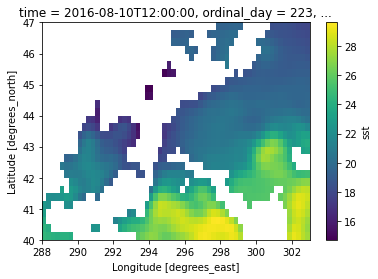

In [18]:
# Check it out
hot_water.sel(time = "2016-08-10").sst.plot()

/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


/opt/conda/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


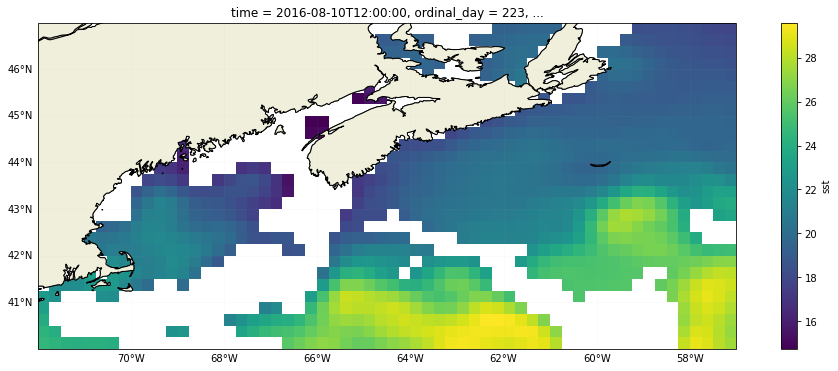

In [19]:
# Better Plot
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
gl = ax.gridlines(draw_labels=True, alpha=0.05, crs=ccrs.PlateCarree())
gl.xlabels_top = gl.ylabels_right = False
hot_water.sel(time = "2016-08-10").sst.plot(ax = ax)

## Make Anomalies

This is just for showing how the anomalies are derived in gridded form

In [24]:
# Calculate a climatology: The mean of each cell based for each day of the year
clim = ref_period['sst'].groupby("ordinal_day").mean('time', keep_attrs = True)
clim

<xarray.DataArray 'sst' (ordinal_day: 366, lat: 28, lon: 60)>
dask.array<stack, shape=(366, 28, 60), dtype=float32, chunksize=(1, 28, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 40.12 40.38 40.62 40.88 ... 46.38 46.62 46.88
  * lon          (lon) float32 288.1 288.4 288.6 288.9 ... 302.4 302.6 302.9
  * ordinal_day  (ordinal_day) int64 1 2 3 4 5 6 7 ... 361 362 363 364 365 366

In [27]:
# Function to match up ordinal day to subtract out mean temperatures 
def calc_anom(daily_sst, daily_clims):
    """
    Return Anomaly for Matching Modified Ordinal Day (day of year 1-366 adjusted for leap-years)
    
    daily_sst : xarray data array of sea surface temperatures containing "MOD" coordinate to pair with daily_clims
    daily_clim : xarray data array of sea surface temperature climatologic means.
    
    """
    # Subtract the climate mean from the observations
    return daily_sst - daily_clims.sel(ordinal_day = daily_sst["ordinal_day"])

In [ ]:
# Calculate Anomalies
anoms = sst.groupby('time').map(lambda x: calc_anom(x, clim))
anoms

In [ ]:
# Flag the anomalies that are Heatwaves

# Anomalies - checks where sst is over threshold, but masks the anomaly dataset
hot_anoms = anoms.groupby(anoms.ordinal_day).where(sst.groupby(sst.modified_ordinal_day) > threshold)

In [ ]:
# Plot what the anomaly values are
fig, ax = plt.subplots(figsize=(16,6),subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', zorder=2)
gl = ax.gridlines(draw_labels=True, alpha=0.05, crs=ccrs.PlateCarree())
gl.xlabels_top = gl.ylabels_right = False
hot_anoms.sel(time = "2016-08-10").sst.plot(ax = ax)

In [ ]:
# # Plot Anomalies that day
# hot_anoms.isel(time = -1).sst.plot()